# Setup!

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.4 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packa

# Importings

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

# Hyperparameters

In [ ]:
num_iterations = 20000 

initial_collect_steps = 1000  
collect_steps_per_iteration = 1  
replay_buffer_max_length = 100000  

# amount of data sampled from the replay buffer to compute the gradient
batch_size = 30 #

learning_rate = 1e-3  
log_interval = 200  

num_eval_episodes = 10 
eval_interval = 1000  

# target network is updated every "target_update_period" iterations
target_update_period = 10 #

# Target Update Period Experiment

step = 200: loss = 30.00806999206543
step = 400: loss = 21.296123504638672
step = 600: loss = 20.47252082824707
step = 800: loss = 21.427154541015625
step = 1000: loss = 27.531570434570312
step = 1000: Average Return = 159.39999389648438
step = 1200: loss = 69.3797607421875
step = 1400: loss = 169.4214324951172
step = 1600: loss = 159.99154663085938
step = 1800: loss = 16.517303466796875
step = 2000: loss = 398.75372314453125
step = 2000: Average Return = 41.599998474121094
step = 2200: loss = 305.1628723144531
step = 2400: loss = 7.482346057891846
step = 2600: loss = 189.5459747314453
step = 2800: loss = 199.73147583007812
step = 3000: loss = 248.89938354492188
step = 3000: Average Return = 22.700000762939453
step = 3200: loss = 8.7223482131958
step = 3400: loss = 157.82681274414062
step = 3600: loss = 10.648510932922363
step = 3800: loss = 131.30722045898438
step = 4000: loss = 7.612153053283691
step = 4000: Average Return = 44.0
step = 4200: loss = 68.73184204101562
step = 4400: los

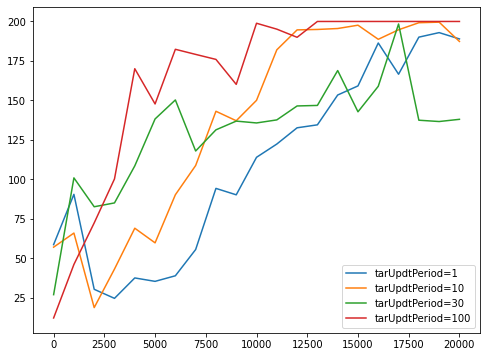

In [ ]:
nTrials = 3
nRewardSample = int(np.ceil((num_iterations + 1) / eval_interval))
rewardSample = np.zeros((4, nRewardSample))
plt.figure(figsize=(8, 6))
for iter_, target_update_period in enumerate([1, 10, 30, 100]):
  rewardSampleTrials = np.zeros((nTrials, nRewardSample))
  for trialId in range(nTrials):
    ## ------------ Environment
    # Set the environment
    env_name = 'CartPole-v0'
    # env = suite_gym.load(env_name)
    train_py_env = suite_gym.load(env_name)
    eval_py_env = suite_gym.load(env_name)
    # Adapt the environment to the TF
    train_env = tf_py_environment.TFPyEnvironment(train_py_env)
    eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

    ## ------------ Agent
    # Set NN parameters
    fc_layer_params = (100,)
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
    train_step_counter = tf.Variable(0)
    # Initialize the agent
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter,
        target_update_period=target_update_period)
    agent.initialize()

    ## ------------ Policies
    # Define a random policy
    random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                    train_env.action_spec())
    ## ------------ Metrics and Evaluation
    def compute_avg_return(environment, policy, num_episodes=10):

      total_return = 0.0
      for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
          action_step = policy.action(time_step)
          time_step = environment.step(action_step.action)
          episode_return += time_step.reward
        total_return += episode_return

      avg_return = total_return / num_episodes
      return avg_return.numpy()[0]

    ## ------------ Replay buffer
    # Define a replay buffer
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_max_length)

    ## ------------ Data Collection
    def collect_step(environment, policy, buffer):
      time_step = environment.current_time_step()
      action_step = policy.action(time_step)
      next_time_step = environment.step(action_step.action)
      traj = trajectory.from_transition(time_step, action_step, next_time_step)
      buffer.add_batch(traj)

    def collect_data(env, policy, buffer, steps):
      for _ in range(steps):
        collect_step(env, policy, buffer)

    # Enrich the replay buffer
    collect_data(train_env, random_policy, replay_buffer, steps=100)
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size, 
        num_steps=2).prefetch(3)
    iterator = iter(dataset)

    ## ------------ Training the agent
    # (Optional) Optimize by wrapping some of the code in a graph using TF function.
    agent.train = common.function(agent.train)

    # Reset the train step
    agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    returns = [avg_return]

    for _ in range(num_iterations):

      # Collect a few steps using collect_policy and save to the replay buffer.
      for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

      # Sample a batch of data from the buffer and update the agent's network.
      experience, unused_info = next(iterator)
      train_loss = agent.train(experience).loss

      step = agent.train_step_counter.numpy()

      if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

      if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
    print("target_update_period: {}, trialId: {}".format(target_update_period, trialId))
    print(returns)
    print("----------")
    rewardSampleTrials[trialId] = returns
  
  rewardSample[iter_] = np.mean(rewardSampleTrials, axis=0)
  iterations = range(0, num_iterations + 1, eval_interval)
  plt.plot(iterations, np.mean(rewardSampleTrials, axis=0), label="tarUpdtPeriod={}".format(target_update_period))

plt.legend(loc = "lower right")
plt.show()

### Discussion

The figure above demonstrate that the bigger the target netwrok update period, the btter; i.e. we converge faster.


Target networks helps to mititgate the chance of divergence in DQN trainging, and it's just like fixing the next value in value iterration.


# Batch Size Experiment

step = 200: loss = 0.016715314239263535
step = 400: loss = 0.23459050059318542
step = 600: loss = 0.5608482360839844
step = 800: loss = 0.0467597059905529
step = 1000: loss = 8.72740364074707
step = 1000: Average Return = 9.100000381469727
step = 1200: loss = 3.1514294147491455
step = 1400: loss = 26.32107925415039
step = 1600: loss = 14.174933433532715
step = 1800: loss = 11.415654182434082
step = 2000: loss = 2.2613325119018555
step = 2000: Average Return = 200.0
step = 2200: loss = 18.78801727294922
step = 2400: loss = 1.0418916940689087
step = 2600: loss = 20.6665096282959
step = 2800: loss = 0.0
step = 3000: loss = 0.7901411652565002
step = 3000: Average Return = 200.0
step = 3200: loss = 2.4563779830932617
step = 3400: loss = 0.0
step = 3600: loss = 944.0523681640625
step = 3800: loss = 7.8930206298828125
step = 4000: loss = 0.1032671108841896
step = 4000: Average Return = 128.1999969482422
step = 4200: loss = 6.777856826782227
step = 4400: loss = 0.2635492980480194
step = 4600: 

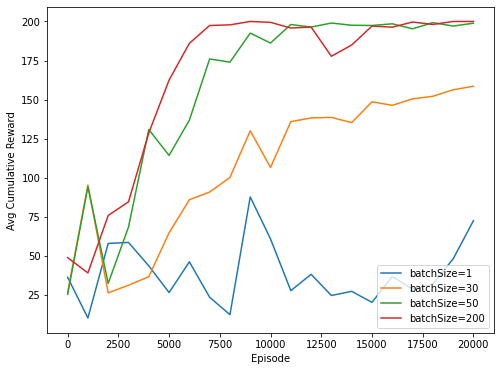

In [ ]:
nTrials = 4
nRewardSample = int(np.ceil((num_iterations + 1) / eval_interval))
rewardSample = np.zeros((4, nRewardSample))
plt.figure(figsize=(8, 6))
for iter_, batch_size in enumerate([1, 30, 50, 200]):
  rewardSampleTrials = np.zeros((nTrials, nRewardSample))
  for trialId in range(nTrials):
    ## ------------ Environment
    # Set the environment
    env_name = 'CartPole-v0'
    # env = suite_gym.load(env_name)
    train_py_env = suite_gym.load(env_name)
    eval_py_env = suite_gym.load(env_name)
    # Adapt the environment to the TF
    train_env = tf_py_environment.TFPyEnvironment(train_py_env)
    eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

    ## ------------ Agent
    # Set NN parameters
    fc_layer_params = (100,)
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
    train_step_counter = tf.Variable(0)
    # Initialize the agent
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter,
        target_update_period=target_update_period)
    agent.initialize()

    ## ------------ Policies
    # Define a random policy
    random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                    train_env.action_spec())
    ## ------------ Metrics and Evaluation
    def compute_avg_return(environment, policy, num_episodes=10):

      total_return = 0.0
      for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
          action_step = policy.action(time_step)
          time_step = environment.step(action_step.action)
          episode_return += time_step.reward
        total_return += episode_return

      avg_return = total_return / num_episodes
      return avg_return.numpy()[0]

    ## ------------ Replay buffer
    # Define a replay buffer
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=agent.collect_data_spec,
        batch_size=train_env.batch_size,
        max_length=replay_buffer_max_length)

    ## ------------ Data Collection
    def collect_step(environment, policy, buffer):
      time_step = environment.current_time_step()
      action_step = policy.action(time_step)
      next_time_step = environment.step(action_step.action)
      traj = trajectory.from_transition(time_step, action_step, next_time_step)
      buffer.add_batch(traj)

    def collect_data(env, policy, buffer, steps):
      for _ in range(steps):
        collect_step(env, policy, buffer)

    # Enrich the replay buffer
    collect_data(train_env, random_policy, replay_buffer, steps=100)
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size, 
        num_steps=2).prefetch(3)
    iterator = iter(dataset)

    ## ------------ Training the agent
    # (Optional) Optimize by wrapping some of the code in a graph using TF function.
    agent.train = common.function(agent.train)

    # Reset the train step
    agent.train_step_counter.assign(0)

    # Evaluate the agent's policy once before training.
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    returns = [avg_return]

    for _ in range(num_iterations):

      # Collect a few steps using collect_policy and save to the replay buffer.
      for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

      # Sample a batch of data from the buffer and update the agent's network.
      experience, unused_info = next(iterator)
      train_loss = agent.train(experience).loss

      step = agent.train_step_counter.numpy()

      if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

      if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
    print("batchSize: {}, trialId: {}".format(batch_size, trialId))
    print(returns)
    print("----------")
    rewardSampleTrials[trialId] = returns
  
  rewardSample[iter_] = np.mean(rewardSampleTrials, axis=0)
  iterations = range(0, num_iterations + 1, eval_interval)
  plt.plot(iterations, np.mean(rewardSampleTrials, axis=0), label="batchSize={}".format(batch_size))

plt.legend(loc = "lower right")
plt.xlabel("Episode")
plt.ylabel("Avg Cumulative Reward")
plt.show()

### Discussion

The figure above demonstrate that the bigger the batch size, the btter; i.e. we converge faster.


Firstly, it stabilizes the learning procedure since it breaks the correlation between successive updates. Secondly, Since it allows multiple step to be taken in the direction of gradient, it accelerates the convergence through reducing the interaction with the environemnt.

When there is a full history of past states, action, and reward, the gradient is exact, but if the number of experiences is reduced, the gradient descent is stochastic.